In [192]:
import pandas as pd
import numpy as np
import requests
import tweepy 
import json
import matplotlib.pyplot as plt
from datetime import datetime
import time

pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 500)

In [5]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')


In [6]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [7]:
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [8]:
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [9]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [10]:
tweet_ids = twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

2356

In [11]:
%%time

import json

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            print("Success")
            outfile.write('\n')
        except Exception as e:
            print("Fail")
            fails_dict[tweet_id] = e
        

print(fails_dict)


1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

In [12]:
tweet_json = pd.read_json('tweet_json.json', lines=True)

tweet_json.head()

tweet_json_sm = tweet_json[['id', 'retweet_count', 'favorite_count']].copy()


In [13]:
tweet_json_sm.head()

,id,retweet_count,favorite_count
0,892420643555336193,6886,32926
1,892177421306343426,5190,28467
2,891815181378084864,3425,21390
3,891689557279858688,7091,35904
4,891327558926688256,7617,34322


In [14]:
tweet_json.head()


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,6886,32926,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,5190,28467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,3425,21390,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,7091,35904,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,7617,34322,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [15]:
twitter_archive_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [16]:
image_archives = image_predictions.merge(twitter_archive_enhanced, left_on='tweet_id', right_on='tweet_id')
image_archives.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [17]:
twitter_full_merged = image_archives.merge(tweet_json, left_on='tweet_id', right_on='id')

In [18]:
twitter_full_merged.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source_y,in_reply_to_status_id_y,in_reply_to_status_id_str,in_reply_to_user_id_y,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,416,2233,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,39,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,35,98,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,Fa

In [19]:
len(twitter_full_merged)

2055

In [20]:
twitter_full_merged.to_csv('twitter_full_merged.csv', index=False)

In [21]:
twitter_full_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   int64              
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   int64              
 3   p1                             2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   p2                             2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   p3                             2055 non-null   object             
 10  p3_conf                 

### ASSESMENT
QUALITY
- Some words are capital in p1, p2 and p3 columns
- The missing names aren't all null. some are "none" or "a" ect.
- Two rows with the same information. created_at and timestamp
- Seven completely empty columns
- Names should are in uppercase
- Timestamp is not in datetime type
- Tweet_id is integer 
- More than one URL in 'expanded_urls'
- Img_num is stored as a integer

TIDINESS
- Unclear column names
- Some columns only contain zeros 'possibly_sensitive' and 'possibly_sensitive_appealable'


In [31]:
twitter_full_merged[twitter_full_merged['p1'] == 1]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source_y,in_reply_to_status_id_y,in_reply_to_status_id_str,in_reply_to_user_id_y,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status


In [32]:
twtr_full_merged_copy = twitter_full_merged.copy()

In [33]:
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   int64              
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   int64              
 3   p1                             2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   p2                             2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   p3                             2055 non-null   object             
 10  p3_conf                 

### CLEAN

DEFINE - CODE - TEST

In [34]:
#DEFINE
# Change all values in P1, P2 and P2 to lowercase

In [35]:
#CODE
twtr_full_merged_copy['p1'] = twtr_full_merged_copy['p1'].str.lower()
twtr_full_merged_copy['p2'] = twtr_full_merged_copy['p2'].str.lower()
twtr_full_merged_copy['p3'] = twtr_full_merged_copy['p3'].str.lower()

In [36]:
#TEST
twtr_full_merged_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source_y,in_reply_to_status_id_y,in_reply_to_status_id_str,in_reply_to_user_id_y,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,416,2233,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,39,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,35,98,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,Fa

In [37]:
#DEFINE
#Change all Values in the "names" column that arent names to Null

In [38]:
#CODE
twtr_full_merged_copy[twtr_full_merged_copy['name'] == 'a']
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('a', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('an', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('the', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('one', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('just', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('all', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('unacceptable', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('not', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('my', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('incredibly', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('infuriating', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('by', 'None')
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].replace('actually', 'None')


In [39]:
#Test
twtr_full_merged_copy.head(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source_y,in_reply_to_status_id_y,in_reply_to_status_id_str,in_reply_to_user_id_y,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,2015-11-15 22:32:08+00:00,666020888022790149,666020888022790144,Here we have a Japanese Irish Setter. Lost eye...,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,416,2233,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,None,None,None,None,None,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,39,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,None,None,None,None,None,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,35,98,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,None,None,None,None,None,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,No

In [40]:
#Define
#Get rid of duplicate rows ('created_at' and 'timestamp', 'tweet_id' and 'id')

In [187]:
#Code
#twtr_full_merged_copy.drop('created_at', inplace=True, axis=1)
#twtr_full_merged_copy.drop('id', inplace=True, axis=1)
#I made this code into comments becasue they will only get errors if I run them more than once

In [188]:
#Test
twtr_full_merged_copy.head(1)

,tweet_id,jpg_url,img_num,prediction_1,p1_conf,p1_dog,prediction_2,p2_conf,p2_dog,prediction_3,p3_conf,p3_dog,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,id_str,full_text,truncated,display_text_range,entities,extended_entities,source_y,in_reply_to_status_id_y,in_reply_to_status_id_str,in_reply_to_user_id_y,in_reply_to_user_id_str,in_reply_to_screen_name,user,place,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,retweeted_status,percentage_rating
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,NaN,NaN,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None,666020888022790144,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,False,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 666020881337073664, 'id_str': '666020881337073664', 'indices': [108, 131], 'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg', 'url': 'https://t.co/BLDqew2Ijj', 'display_url': 'pic.twitter.com/BLDqew2Ijj', 'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 960, 'h': 720, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 960, 'h': 720, 'resize': 'fit'}, 'small': {'w': 680, 'h': 510, 'resize': 'fit'}}}]}","{'media': [{'id': 666020881337073664, 'id_str': '666020881337073664', 'indices': [108, 131], 'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg', 'url': 'https://t.co/BLDqew2Ijj', 'display_url': 'pic.twitter.com/BLDqew2Ijj', 'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 960, 'h': 720, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 960, 'h': 720, 'resize': 'fit'}, 'small': {'w': 680, 'h': 510, 'resize': 'fit'}}}]}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': 'all our links ➜', 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➜ WeRateDogs partnerships@weratedogs.com | nonprofit: @15outof10 ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀', 'url': 'https://t.co/YPc2Xq4Va2', 'entities': {'url': {'urls': [{'url': 'https://t.co/YPc2Xq4Va2', 'expanded_url': 'http://links.weratedogs.com', 'display_url': 'links.weratedogs.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 9375196, 'friends_count': 20, 'listed_count': 7833, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 147503, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 17487, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/imag...",None,False,416,2233,False,False,en,NaN,0.8


In [43]:
#Define
#Get rid of the 7 completely emptpy columns ('geo', 'coordinates', 'contributors', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'quoted_status')

In [108]:
#Code
#twtr_full_merged_copy.drop('geo', inplace=True, axis=1)
#twtr_full_merged_copy.drop('coordinates', inplace=True, axis=1)
#twtr_full_merged_copy.drop('contributors', inplace=True, axis=1)
#twtr_full_merged_copy.drop('quoted_status_id', inplace=True, axis=1)
#twtr_full_merged_copy.drop('quoted_status_id_str', inplace=True, axis=1)
#twtr_full_merged_copy.drop('quoted_status_permalink', inplace=True, axis=1)
#twtr_full_merged_copy.drop('quoted_status', inplace=True, axis=1)
#Turned into comments so I can't run it againa nd get errors

In [109]:
#Test
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   object             
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   object             
 3   prediction_1                   2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   prediction_2                   2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   prediction_3                   2055 non-null   object             
 10  p3_conf                 

In [46]:
#Define
#Change values in 'names' to lowercase

In [47]:
#Code
twtr_full_merged_copy['name'] = twtr_full_merged_copy['name'].str.lower()

In [48]:
#Test
twtr_full_merged_copy['name']

0           none
1           none
2           none
3           none
4           none
          ...   
2050    franklin
2051       darla
2052      archie
2053       tilly
2054     phineas
Name: name, Length: 2055, dtype: object

In [49]:
#Define
#Change 'timestamp' to datetime format

In [50]:
#Code
twtr_full_merged_copy['timestamp'] = pd.to_datetime(twtr_full_merged_copy['timestamp'])

In [51]:
#test
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   int64              
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   int64              
 3   p1                             2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   p2                             2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   p3                             2055 non-null   object             
 10  p3_conf                 

In [52]:
#Define
#Change 'tweet_id' to object instead of integer

In [53]:
#Code
twtr_full_merged_copy['tweet_id'] = twtr_full_merged_copy['tweet_id'].astype(object)

In [54]:
#Test
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   object             
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   int64              
 3   p1                             2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   p2                             2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   p3                             2055 non-null   object             
 10  p3_conf                 

In [55]:
#Define
#change the 'expande_urls' column to only have one URL

In [56]:
#Code
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
twtr_full_merged_copy['expanded_urls']= twtr_full_merged_copy['expanded_urls'].str.extract(pattern, expand=False).str.strip()

In [58]:
#Test

twtr_full_merged_copy['expanded_urls']


0       https://twitter.com/dog_rates/status/666020888...
1       https://twitter.com/dog_rates/status/666029285...
2       https://twitter.com/dog_rates/status/666033412...
3       https://twitter.com/dog_rates/status/666044226...
4       https://twitter.com/dog_rates/status/666049248...
                              ...                        
2050    https://twitter.com/dog_rates/status/891327558...
2051    https://twitter.com/dog_rates/status/891689557...
2052    https://twitter.com/dog_rates/status/891815181...
2053    https://twitter.com/dog_rates/status/892177421...
2054    https://twitter.com/dog_rates/status/892420643...
Name: expanded_urls, Length: 2055, dtype: object

In [61]:
#twtr_full_merged_copy.to_csv('check_expanded_urls.csv', index=False)

In [62]:
#Define
#Change img_num to a object instead of integer

In [63]:
#Code
twtr_full_merged_copy['img_num'] = twtr_full_merged_copy['img_num'].astype(object)

In [64]:
#Test
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   object             
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   object             
 3   p1                             2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   p2                             2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   p3                             2055 non-null   object             
 10  p3_conf                 

In [65]:
#Define
#Some column names are unclear as to what the column contains 'p1', 'p2', 'p3', change to prediction_1, ect

In [68]:
#Code
twtr_full_merged_copy.rename(columns={'p1': 'prediction_1', 'p2': 'prediction_2', 'p3': 'prediction_3'}, inplace=True)

In [69]:
#Test
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2055 non-null   object             
 1   jpg_url                        2055 non-null   object             
 2   img_num                        2055 non-null   object             
 3   prediction_1                   2055 non-null   object             
 4   p1_conf                        2055 non-null   float64            
 5   p1_dog                         2055 non-null   bool               
 6   prediction_2                   2055 non-null   object             
 7   p2_conf                        2055 non-null   float64            
 8   p2_dog                         2055 non-null   bool               
 9   prediction_3                   2055 non-null   object             
 10  p3_conf                 

In [79]:
#Define
#Delete columns only containing zeros 'possibly_sensitive' and 'possibly_sensitive_appealable'

In [138]:
#Code
twtr_full_merged_copy.drop('possibly_sensitive', inplace=True, axis=1)
twtr_full_merged_copy.drop('possibly_sensitive_appealable', inplace=True, axis=1)

In [139]:
#Test
twtr_full_merged_copy.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_1', 'p1_conf', 'p1_dog',
       'prediction_2', 'p2_conf', 'p2_dog', 'prediction_3', 'p3_conf',
       'p3_dog', 'in_reply_to_status_id_x', 'in_reply_to_user_id_x',
       'timestamp', 'source_x', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'created_at', 'id', 'id_str',
       'full_text', 'truncated', 'display_text_range', 'entities',
       'extended_entities', 'source_y', 'in_reply_to_status_id_y',
       'in_reply_to_status_id_str', 'in_reply_to_user_id_y',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'place',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'retweeted_status'],
      dtype='object')

In [141]:
#Define
#Add a percentage rating for easier analysis

In [163]:
#Code
twtr_full_merged_copy['percentage_rating'] = twtr_full_merged_copy['rating_numerator']/ twtr_full_merged_copy['rating_denominator']


In [164]:
#Test 
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2055 non-null   object             
 1   jpg_url                     2055 non-null   object             
 2   img_num                     2055 non-null   object             
 3   prediction_1                2055 non-null   object             
 4   p1_conf                     2055 non-null   float64            
 5   p1_dog                      2055 non-null   bool               
 6   prediction_2                2055 non-null   object             
 7   p2_conf                     2055 non-null   float64            
 8   p2_dog                      2055 non-null   bool               
 9   prediction_3                2055 non-null   object             
 10  p3_conf                     2055 non-null   float64         

In [149]:
#Define
#Change null dog names to null values

In [150]:
#Code
twtr_full_merged_copy['name'].replace({'none': None},inplace =True, regex= True)


In [154]:
#Test
twtr_full_merged_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2055 entries, 0 to 2054
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2055 non-null   object             
 1   jpg_url                     2055 non-null   object             
 2   img_num                     2055 non-null   object             
 3   prediction_1                2055 non-null   object             
 4   p1_conf                     2055 non-null   float64            
 5   p1_dog                      2055 non-null   bool               
 6   prediction_2                2055 non-null   object             
 7   p2_conf                     2055 non-null   float64            
 8   p2_dog                      2055 non-null   bool               
 9   prediction_3                2055 non-null   object             
 10  p3_conf                     2055 non-null   float64         

In [189]:
twtr_data_clean_master = twtr_full_merged_copy.copy()

In [190]:
twtr_data_clean_master.to_csv('twitter_archive_master.csv', index=False)

### Analyze



In [167]:
#Most used dog names

In [168]:
twtr_data_clean_master['name'].value_counts(dropna=True)

charlie           10
penny             10
cooper            10
tucker            10
oliver            10
lucy               9
bo                 8
winston            8
sadie              8
lola               8
toby               7
daisy              7
stanley            6
scout              6
rusty              6
bailey             6
jax                6
milo               6
koda               6
bella              6
dave               6
buddy              5
alfie              5
leo                5
oscar              5
larry              5
louis              5
chester            5
chip               4
finn               4
bentley            4
very               4
winnie             4
sophie             4
derek              4
cassie             4
archie             4
ruby               4
duke               4
brody              4
oakley             4
phil               4
clarence           4
bear               4
scooter            4
maggie             4
dexter             4
sunny        

Charlie. Penny, Cooper, Tucker, and Oliver are the most used dog names on this list, all coming in at 10 different occurances. 

In [162]:
#Average rating for dogs 

In [170]:
twtr_data_clean_master['percentage_rating'].mean() * 100

116.95294972667234

It looks like the average rating for all the dogs are above 100%! These are some spectacular dogs.

In [171]:
#The tweet with the most favorites

In [180]:
pd.options.display.max_colwidth = 1000

In [201]:
print(twtr_data_clean_master['favorite_count'].max())

141865


In [181]:
x = twtr_data_clean_master['favorite_count'].max()

tweet=twtr_data_clean_master.loc[twtr_data_clean_master['favorite_count'] == x , 'text']
print(tweet)

1220    Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
Name: text, dtype: object


In [202]:
image=twtr_data_clean_master.loc[twtr_data_clean_master['favorite_count'] == x , 'jpg_url']
print(image)

1220    https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg
Name: jpg_url, dtype: object


The most favorited tweet in this data frame is listed above along with the number of favorites and the picture's link.

In [182]:
# Do ratings for dogs get more generous as time goes on?

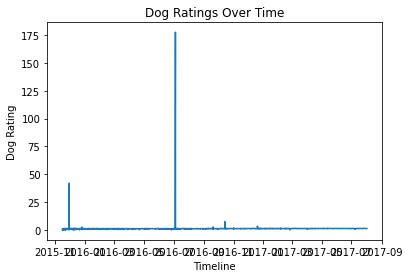

In [194]:
plt.plot(twtr_data_clean_master['timestamp'], twtr_data_clean_master['percentage_rating'])
 
plt.xlabel('Timeline')

plt.ylabel('Dog Rating')
  

plt.title('Dog Ratings Over Time')
  
plt.show()



Text(0.5, 1.0, 'Dog Ratings Over Time')

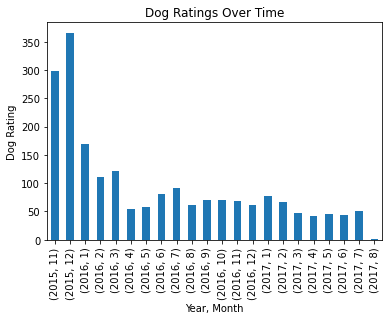

In [200]:
twtr_data_clean_master['timestamp'].groupby([twtr_data_clean_master['timestamp'].dt.year, twtr_data_clean_master["timestamp"].dt.month]).count().plot(kind="bar")

plt.xlabel('Year, Month')

plt.ylabel('Dog Rating')
  

plt.title('Dog Ratings Over Time')

It looks like the opposite is true, the ratings started off higher in the beginning and went down over time, then started to level out. 